# IMPORT PACKAGES

In [27]:
import pandas as pd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import vector_tools as vt
#import khFunctions as khf
%matplotlib ipympl
from datetime import timedelta
import re
from physoce import tseries as ts #https://github.com/physoce/physoce-py

#Scipy
from scipy import integrate
from scipy.integrate import quad_vec
from scipy import stats
from scipy.stats import chi2
from scipy.stats.distributions import t
from scipy import signal
from scipy.signal import welch 
from scipy.signal import periodogram
from scipy.signal import argrelextrema
from scipy.special import gamma
from scipy.optimize import curve_fit

# IMPORT, FLAG, AND CLEAN DATA

In [3]:
#Use .dat, .vhd. and .sen files to generate a dataset that matches format used by 
#Wheeler and Giddings 2023 to be usable in their functions
datfile1 = 'ADV/DEP204.dat'
vhdfile1 = 'ADV/DEP204.vhd'
senfile1 = 'ADV/DEP204.sen'

datfile2 = 'ADV/DEP205.dat'
vhdfile2 = 'ADV/DEP205.vhd'
senfile2 = 'ADV/DEP205.sen'

fs = 32

#Create the raw dataset 
adv1_raw = vt.vector_to_ds(datfile1, vhdfile1, senfile1, fs)
adv2_raw = vt.vector_to_ds(datfile2, vhdfile2, senfile2, fs)

#Add in metadata from .hdr file and project information
headerFile1 = 'ADV/DEP204.hdr'
headerFile2 = 'ADV/DEP205.hdr'
metadata_list = [('Creator', 'Logan A. Grady'), ('Contact information', 'logan.grady@sjsu.edu'), ('Description', 'Raw data with qc flags and deployment/retrieval times removed'),
 ('Lat', 36.56195999999164), ('Lon', -121.94174126537672), ('Pressure sensor height (m)', .58), ('Velocity sample height (m)', .94)]

adv1_raw = vt.vector_metadata(adv1_raw, headerFile1, metadata_list)
adv2_raw = vt.vector_metadata(adv2_raw, headerFile2, metadata_list)

#Flag the raw dataset
adv1_raw = vt.vectorFlag(adv1_raw)
adv2_raw = vt.vectorFlag(adv2_raw)

#Trim the bad times during adv deployment and recovery
adv1_raw = adv1_raw.sel(dict(time=slice('2022-08-02T11:00:00.000000000', '2022-08-11T11:00:00.000000000'),
                                     time_sen=slice('2022-08-02T11:00:00.000000000', '2022-08-11T11:00:00.000000000'),
                                     time_start=slice('2022-08-02T11:00:00.000000000', '2022-08-11T11:00:00.000000000')))
adv2_raw = adv2_raw.sel(dict(time=slice('2022-08-15T09:00:00.000000000', '2022-08-30T11:00:00.000000000'),
                                     time_sen=slice('2022-08-15T09:00:00.000000000', '2022-08-30T11:00:00.000000000'),
                                     time_start=slice('2022-08-15T09:00:00.000000000', '2022-08-30T11:00:00.000000000')))

Importing data
Creating timelines
Creating xarray dataset
Assigning dataset attributes
Importing data
Creating timelines
Creating xarray dataset
Assigning dataset attributes
Flagging data
Flagging data


In [16]:
#Look at the two datasets to make sure all variables and attributes are present
#adv1_raw
adv2_raw

<xarray.Dataset>
Dimensions:                 (time_start: 362, time_sen: 434763, time: 13900800)
Coordinates:
  * time                    (time) datetime64[ns] 2022-08-15T09:40:00 ... 202...
  * time_sen                (time_sen) datetime64[ns] 2022-08-15T09:00:00 ......
  * time_start              (time_start) datetime64[ns] 2022-08-15T09:40:00 ....
Data variables: (12/46)
    BurstCounter            (time_start) int64 4 5 6 7 8 ... 361 362 363 364 365
    NoVelSamples            (time_start) int64 38400 38400 38400 ... 38400 38400
    ErrorCode               (time_sen) int64 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0
    StatusCode              (time_sen) int64 1110001 1110001 ... 1110001 1110001
    BatVolt                 (time_sen) float64 13.4 13.4 13.4 ... 9.4 9.4 9.4
    SoundSpeed              (time_sen) float64 1.495e+03 1.495e+03 ... 1.5e+03
    ...                      ...
    EastAcceleration_flag   (time) int32 0 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1
    NorthAcceleration_flag  (time) int32 0 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1
    UpAcceleration_flag     (time) int32 0 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1
    CSPD_flag               (time) int32 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1
    CSPDAcceleration_flag   (time) int32 0 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1
    CDIRdelta_flag          (time) int32 1 1 1 1 1 1 1 1 1 ... 1 1 1 3 1 1 1 1 1
Attributes: (12/46)
    Creator:                             Logan A. Grady
    Contact information:                 logan.grady@sjsu.edu
    Description:                         Raw data with qc flags and deploymen...
    Lat:                                 36.56195999999164
    Lon:                                 -121.94174126537672
    Pressure sensor height (m):          0.58
    ...                                  ...
    Wrap mode:                           OFF
    Deployment time:                     8/15/2022 6:40:00 AM
    Comments:                            Third deployment in Stillwater Cove ...
    Flag score:                          [1, 3, 4]
    Grade definition:                    Pass = 1; Suspect = 3; Fail = 4
    Flag description:                    Flag grading system is based on QART...

In [14]:
#Export usable data
adv1_raw.to_netcdf('ADV/adv1_raw.nc')
adv2_raw.to_netcdf('ADV/adv2_raw.nc')

In [5]:
#Import usable data
adv1Raw = xr.open_dataset('ADV/adv1_raw.nc')
adv2Raw = xr.open_dataset('ADV/adv2_raw.nc')

# DESPIKING DATA

Despike adv data using the expanding ellipsoid method from Wheeler & Giddings 2023
- Nan's out all data that does not pass correlation, SNR, and tilt tests
    - All data with a single beam correlation below 60%, SNR below 10 dB, or an instrument tilt <BR>
    of more than 5 degrees was removed
- Uses expanding ellipse algorithm to despike data
    - Based on the despiking method used in Goring and Nikora (2002), which uses a 3D ellipse<BR>
    to despike data that falls outside of the ellipse
    - Wheeler and Giddings (2023) build upon this method by creating an "expanding ellipse", which<BR>
    iteratively grows the ellipse by 1% until the number of points from the previous ellipse to the<BR>
    new ellipse is less than 95% of the density of points
    - Points outside of the ellipse are marked as spikes and replaced with the last valid point in the time series
- Rotate's velocities to principle axes
- Keeps boolean mask array of data points that have been filtered and despiked for future interpolation

Simple correlation/SNR/tilt filter
- Conducts all the sensor tests, but does not conduct the more complex despiking algorithm

In [ ]:
#Conditions
badSections = [] #Bad sectiions already removed during data import
reverse = True #Set variable for reversing direction after rotation if needed
corrCutoff = 50 #%
snrCutoff = 10 #dB
tiltCutoff = .1 #Equivalent to more than 5 degrees of pitch or roll

#'ProcessVec' function from Wheeler & Giddings (2023) has been modified to work with my dataset, but the core algorithm remains unchanged
#Removes data that fails correlation/snr/tilt tests, as well as despikes data that falls outside of "expanding ellipse" algorithm
adv1Despiked = vt.ProcessVec(adv1_raw,badSections,corrCutoff,snrCutoff,tiltCutoff,reverse=reverse,expand = True,lp = 1/20,expSize = 0.01,expEnd = 0.95)
adv2Despiked = vt.ProcessVec(adv2_raw,badSections,corrCutoff,snrCutoff,tiltCutoff,reverse=reverse,expand = True,lp = 1/20,expSize = 0.01,expEnd = 0.95)

In [5]:
#Export despiked data
adv1Despiked.to_netcdf('ADV/adv1_despiked.nc')
adv2Despiked.to_netcdf('ADV/adv2_despiked.nc')

# Repairing data gaps
- Three methods
    - Full linear interpolation across all gaps
    - Partial interpolation over gaps <= 1s and averaging longer gaps with the average of the removed data
    - Partial interpolation over gaps <= 1s and patching longer gaps
- For this study, gaps have a large range between less than 1 second to multiple minutes
    - many of these gaps are considered too large for full linear interpolation
    - Patching unnecessarily removes data that can still be useful during analysis
    - Partial interpolation of short gaps, while averaging larger gaps is the best compromise for this <BR>
    dataset

In [3]:
adv1Despiked=xr.open_dataset('ADV/adv1_despiked.nc')
adv2Despiked=xr.open_dataset('ADV/adv2_despiked.nc')

In [4]:
adv1IntAvg = vt.InterpAvg_ADV(adv1Despiked, interpTimeDelta = 1, reversePrincVel = True)
adv2IntAvg = vt.InterpAvg_ADV(adv2Despiked, interpTimeDelta = 1, reversePrincVel = True)

Interpolating gaps <= 1s
Averaging gaps > 1s
Recalculating CSPD and CDIR
Recalculating principle velocities
reversing direction so primary is in flooding direction
Interpolating gaps <= 1s
Averaging gaps > 1s
Recalculating CSPD and CDIR
Recalculating principle velocities
reversing direction so primary is in flooding direction


In [22]:
#Full linear interpolation of gaps
#adv1Int = vt.fullInterpVec(adv1Despiked)
#adv2Int = vt.fullInterpVec(adv2Despiked)

#Inerpolate gaps <= 1s and and patch the remaining gaps
#adv1Patch = vt.patchVec(adv1Despiked)
#adv2Patch = vt.patchVec(adv2Despiked)

Linearly interpolating dataset
Evaluating ratio of nans leftover in the dataset
Linearly interpolating dataset
Evaluating ratio of nans leftover in the dataset


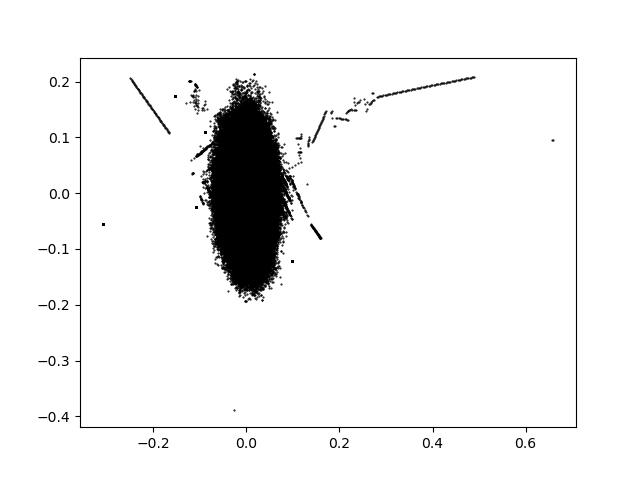

In [9]:
plt.figure()
plt.plot(adv1Final.Secondary, adv1Final.Primary, '.k', ms = 1)

# Wavenumber integral Jlm
- Takes equation A13 from Gerbi et al. (2009) and applies it to the despiked and repaired datasets

In [ ]:
#Calculate the wavenumber integral for all datasets
adv1Final = vt.JlmIntegral(adv1IntAvg, 200)
adv2Final = vt.JlmIntegral(adv2IntAvg, 200)

In [76]:
#Export the Organized, cleaned, despiked, gap-repaired datasets with wavenumber integrals included
adv1Final.to_netcdf('ADV/adv1_final2.nc')
adv2Final.to_netcdf('ADV/adv2_final2.nc')

In [ ]:
#For the other repair methods
#Jlm1Int = vt.JlmIntegral(adv1Int)
#Jlm2Int = vt.JlmIntegral(adv2Int)
#Jlm1Patch = vt.JlmIntegral(adv1Patch)
#Jlm2Patch = vt.JlmIntegral(adv2Patch)

#adv1Int.to_netcdf('ADV/adv1Int.nc')
#adv2Int.to_netcdf('ADV/adv2Int.nc')

#adv1Patch.to_netcdf('ADV/adv1Patch.nc')
#adv2Patch.to_netcdf('ADV/adv2Patch.nc')

In [24]:
#adv1Final = xr.open_dataset('ADV/adv1_final.nc')
#adv2Final = xr.open_dataset('ADV/adv2_final.nc')

## If phase wrapping is present
- Convert velocities from ENU to beam by using the transformation matrix in .hdr files
    - The following code is based on a MatLab script available on NORTEK's FAQ forums:
        https://support.nortekgroup.com/hc/en-us/articles/360029820971-How-is-a-coordinate-transformation-done-
        - Most relevant information is available in the .hdr file
        - You will need the transformation matrix, as well as heading, pitch, and roll data for each sample to make the conversions
    - Once velocities have been converted, calculate the ambiguous velocity V_amb
    - Run a patch over the entire BEAM velocity dataset
        - If phase wrap is negative: newvel = oldvel + 2*V_amb
        - If phase wrap is positive: newvel = oldvel - 2*V_amb
    -Convert patched velocities back to ENU for more user-friendly data

In [52]:
# Transformation matrix located in .hdr file as 'Transformation matrix'

T = np.array([[2.7249, -1.3770, -1.3503], #Convert matrix to multidimensional numpy array
   [-0.0161, 2.3442, -2.3308],
   [0.3472, 0.3455, 0.3389]])

# Heading, pitch and roll are the angles output in the data in degrees
# Convert to radians
hh = np.pi*(adv1_flagged['Heading']-90)/180 #Creates list of hh, pp, and rr for all datapoints
pp = np.pi * (adv1_flagged['Pitch']/180)
rr = np.pi * (adv1_flagged['Roll']/180)

# Generate empty arrays to be populated by resulting beam velocities
beam1 = np.empty(len(adv1_flagged)) # Already created to be the length of the dataset to save processing time
beam2 = np.empty(len(adv1_flagged))
beam3 = np.empty(len(adv1_flagged))

In [ ]:
# Calculate heading matrix and tilt matrix for each data point and convert ENU velocities to beam velocities

# for loop iterates for each data point
for i in range(0,len(adv1_flagged)):
    if i % 1000000 == 0: # Progress check every 1000000 rows
                print('Currently on row:', i)
            
    H = np.array([[np.cos(hh[i]), np.sin(hh[i]), 0], # Makes the heading matrix for row i
                  [-np.sin(hh[i]), np.cos(hh[i]), 0], 
                  [0, 0, 1]])
    
    P = np.array([[np.cos(pp[i]), -np.sin(pp[i])*np.sin(rr[i]), -np.cos(rr[i])*np.sin(pp[i])], # Makes the tilt matrix for row i
                  [0, np.cos(rr[i]), -np.sin(rr[i])], 
                  [np.sin(pp[i]), np.sin(rr[i])*np.cos(pp[i]), np.cos(pp[i])*np.cos(rr[i])]])
    
    R = H*P*T #Product of transformation, heading, and tilt matrix creates conversion matrix R

    # Retrieves ENU velocities from row i to be converted by R[i]
    enu = np.array([adv1_flagged['Velocity_East(m/s)'][i], adv1_flagged['Velocity_North(m/s)'][i], adv1_flagged['Velocity_Up(m/s)'][i]])
    
    beam1[i] = np.dot(np.linalg.inv(R),enu)[0]
    beam2[i] = np.dot(np.linalg.inv(R),enu)[1]
    beam3[i] = np.dot(np.linalg.inv(R),enu)[2]

### Calculate v_amb
 - v_amb = VR * 2
 - VR = c/(4 * f * tlag(s))
 - c = 1530 (speed of sound measured by instrument)
 - f = instrument frequency (6000kHz)
 - tlag (for vector) = 50/480000 (50 is from system 38 in .hdr file, which indicates nominal velocity of 1m/s)